In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Load JSON data
with open('data/usersWithMealsAndDqq.json', 'r') as f:
    data = json.load(f)

In [2]:
# Create a dictionary to hold user time series
timeseries_dict = {}

for entry in data:
    #if(entry['user']['role'] != 'CONTROLL'):
    #    continue
    user_name = entry['user']['displayName']
    meals = entry['dailyGroupedMeals']

    # Convert to a DataFrame
    df = pd.DataFrame([
        {
            'date': pd.to_datetime(meal['day']),
            'fgds': meal['dqq']['fgds']
        }
        for meal in meals
    ])

    # Set date as index and sort
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

    # Store in dict
    timeseries_dict[user_name] = df

# Combine all user series into a single DataFrame with aligned dates
all_dates = pd.Index(sorted({date for df in timeseries_dict.values() for date in df.index}))

combined_df = pd.DataFrame(index=all_dates)
for user, df in timeseries_dict.items():
    combined_df[user] = df['fgds']

In [ ]:
# Save the combined DataFrame to a CSV file
combined_df.to_csv('data/combined_df.csv')

Manually fix some data issues


In [14]:
# Load the combined DataFrame from CSV
combined_df = pd.read_csv('data/combined_df_fixed.csv', delimiter=";", index_col=0, parse_dates=True)

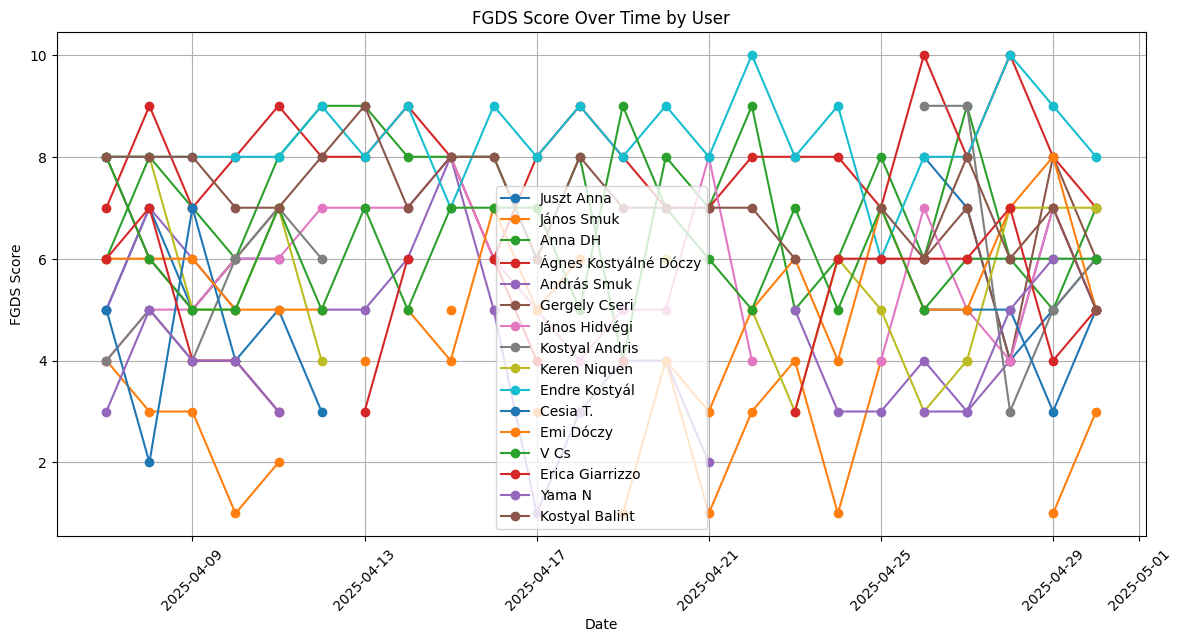

In [15]:
# Plotting
plt.figure(figsize=(12, 6))
for user in combined_df.columns:
    plt.plot(combined_df.index, combined_df[user], label=user, marker='o', linestyle='-')

plt.xlabel('Date')
plt.ylabel('FGDS Score')
plt.title('FGDS Score Over Time by User')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [16]:
# Create dictionaries to hold user time series and roles
timeseries_dict = {}
role_dict = {}
user_ids = []

for entry in data:
    user_name = entry['user']['displayName']
    role = entry['user']['role']
    meals = entry['dailyGroupedMeals']

    user_ids.append(user_name)

    df = pd.DataFrame([
        {
            'date': pd.to_datetime(meal['day']),
            'fgds': meal['dqq']['fgds']
        }
        for meal in meals
    ])

    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

    timeseries_dict[user_name] = df
    role_dict[user_name] = role

# Group users by role
control_users = [user for user, role in role_dict.items() if role == 'CONTROLL']
subject_users = [user for user, role in role_dict.items() if role == 'SUBJECT']
admin_users = [user for user, role in role_dict.items() if role == 'ADMIN']

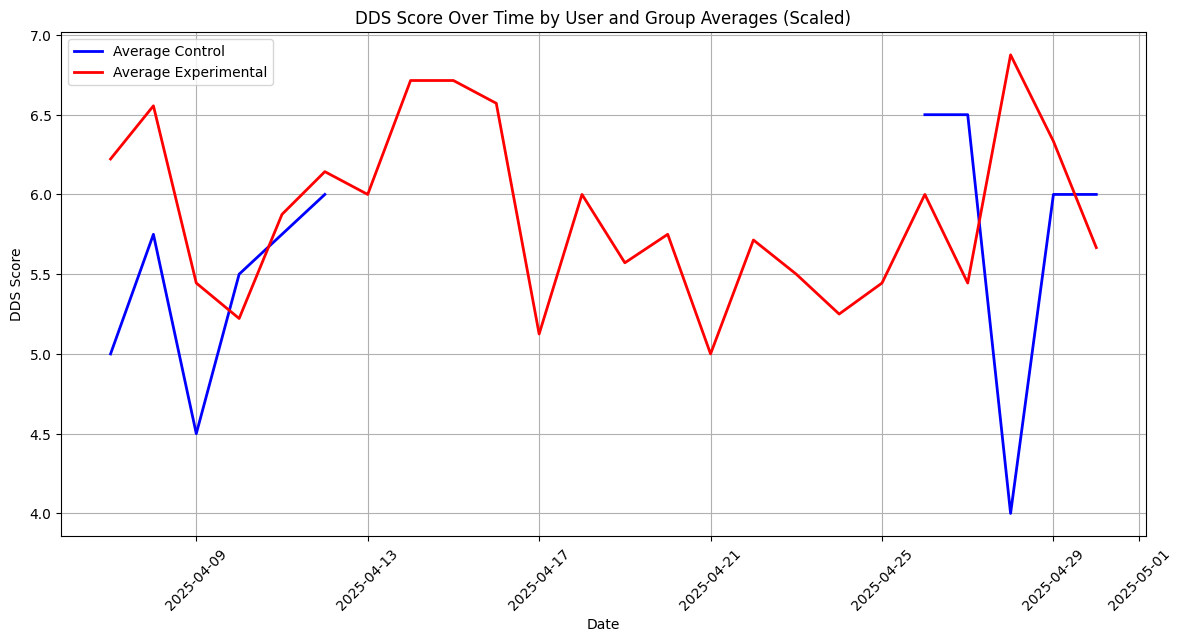

In [18]:
# Function to compute scaled average
def average(users):
    data = combined_df[users]
    mean_series = data.mean(axis=1)
    return mean_series


# Compute scaled averages
timeseries_control = average(control_users)
timeseries_subject = average(subject_users)
timeseries_admin = average(admin_users)

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(timeseries_control.index, timeseries_control, label='Average Control', color='blue', linewidth=2)
plt.plot(timeseries_subject.index, timeseries_subject, label='Average Experimental', color='red', linewidth=2)
#plt.plot(timeseries_admin.index, timeseries_admin, label='Average ADMIN', color='green', linewidth=2)

plt.xlabel('Date')
plt.ylabel('DDS Score')
plt.title('DDS Score Over Time by User and Group Averages (Scaled)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


Subject Group Trendline:
  Slope: -0.0114 (FGDS change per day)
  Intercept: 8453.7901


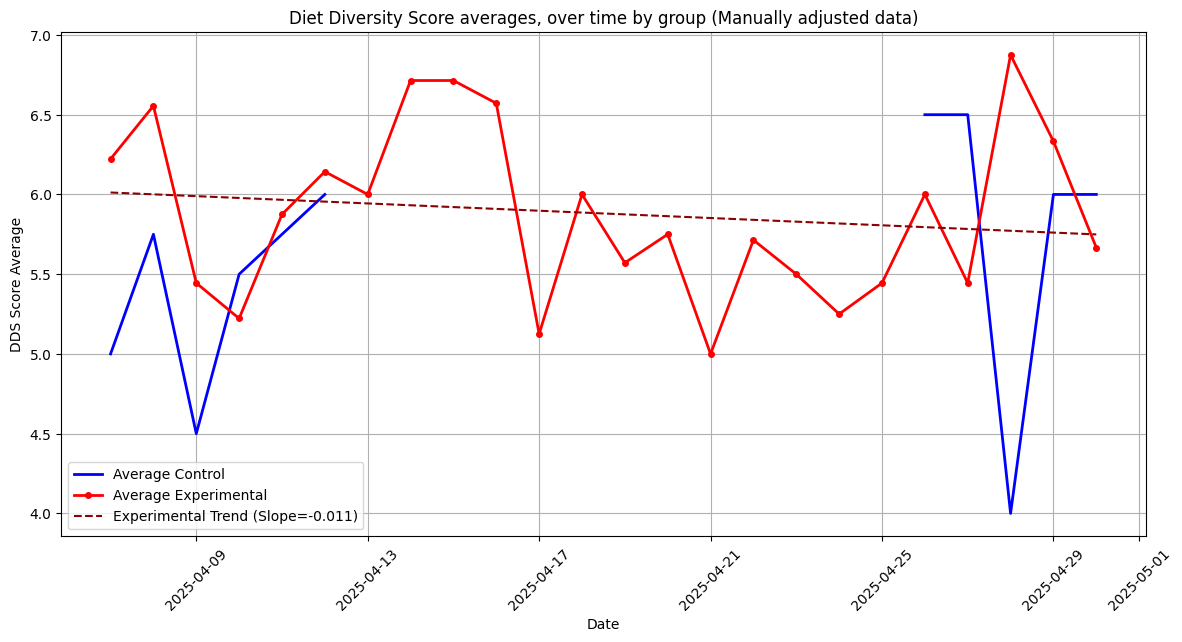

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Import numpy
from sklearn.linear_model import LinearRegression # Import LinearRegression

# Create dictionaries to hold user time series and roles
timeseries_dict = {}
role_dict = {}
user_ids = []

for entry in data:
    # --- Basic error checking for missing keys ---
    if not entry or 'user' not in entry or 'displayName' not in entry['user'] or 'role' not in entry['user'] or 'dailyGroupedMeals' not in entry:
        print(f"Skipping potentially malformed entry: {entry}")
        continue
    # --- End of error checking ---

    user_name = entry['user']['displayName']
    role = entry['user']['role']
    meals = entry['dailyGroupedMeals']

    user_ids.append(user_name)

    # --- Check if meals is None or empty ---
    if meals is None or not meals:
         df = pd.DataFrame(columns=['date', 'fgds']) # Create empty dataframe
    else:
        valid_meals = []
        for meal in meals:
             # Check if meal and necessary keys exist
             if meal and 'day' in meal and 'dqq' in meal and isinstance(meal['dqq'], dict) and 'fgds' in meal['dqq']:
                 valid_meals.append({
                     'date': pd.to_datetime(meal['day']),
                     'fgds': meal['dqq']['fgds']
                 })
             else:
                 # Optional: print a warning about invalid meal structure
                 # print(f"Warning: Invalid meal structure found for user {user_name}: {meal}")
                 pass # Silently skip invalid meals

        if not valid_meals:
             df = pd.DataFrame(columns=['date', 'fgds']) # Empty if no valid meals
        else:
            df = pd.DataFrame(valid_meals)
    # --- End of meals check ---

    if not df.empty:
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
    else:
        # Handle cases where a user might have no valid meal data
        # Assign an empty DataFrame with the correct structure but no rows
         df = pd.DataFrame(columns=['fgds'], index=pd.to_datetime([]))


    timeseries_dict[user_name] = df
    role_dict[user_name] = role

# Combine all user series into a single DataFrame
all_dates = pd.Index(sorted({date for df in timeseries_dict.values() for date in df.index}))

# Group users by role
control_users = [user for user, role in role_dict.items() if role == 'CONTROLL']
subject_users = [user for user, role in role_dict.items() if role == 'SUBJECT']
admin_users = [user for user, role in role_dict.items() if role == 'ADMIN']


# Compute scaled averages
timeseries_control = average(control_users)
timeseries_subject = average(subject_users)
timeseries_admin = average(admin_users)


# --- Linear Regression for SUBJECT group ---

# 1. Prepare data: Drop NaNs and convert dates to numerical format
subject_data_clean = timeseries_subject.dropna()
if not subject_data_clean.empty:
    X = subject_data_clean.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = subject_data_clean.values

    # 2. Fit Linear Regression model
    model = LinearRegression()
    model.fit(X, y)

    # 3. Predict trendline values
    y_pred = model.predict(X)

    # Get slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"\nSubject Group Trendline:")
    print(f"  Slope: {slope:.4f} (FGDS change per day)")
    print(f"  Intercept: {intercept:.4f}")

else:
    print("\nCannot fit trendline for SUBJECT group: No valid data points.")
    y_pred = None # Set to None if no data

# --- End of Linear Regression ---


# Plotting
plt.figure(figsize=(12, 6))

if not timeseries_control.empty:
    plt.plot(timeseries_control.index, timeseries_control, label='Average Control', color='blue', linewidth=2)
if not timeseries_subject.empty:
    plt.plot(timeseries_subject.index, timeseries_subject, label='Average Experimental', color='red', linewidth=2, marker='o', linestyle='-', markersize=4) # Plot points for subject average
    # Plot the trendline only if it was calculated
    if y_pred is not None:
         plt.plot(subject_data_clean.index, y_pred, color='darkred', linestyle='--', label=f'Experimental Trend (Slope={slope:.3f})')


# Optional: Plot admin average if needed and data exists
#if not timeseries_admin.empty:
#    plt.plot(timeseries_admin.index, timeseries_admin, label='Average ADMIN', color='green', linewidth=2)


plt.xlabel('Date')
plt.ylabel('DDS Score Average')
plt.title('Diet Diversity Score averages, over time by group (Manually adjusted data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [112]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates # For better date formatting

# Ensure the output directory exists
output_dir = 'data/user_fgds_charts'
os.makedirs(output_dir, exist_ok=True)

# Iterate through each user (column) in the combined_df
for user_name in combined_df.columns:
    # Extract the series for the current user
    user_series = combined_df[user_name]

    # Drop missing values for plotting and regression
    user_data_clean = user_series.dropna()

    # Skip user if they have no data points
    if user_data_clean.empty:
        print(f"Skipping {user_name}: No FGDS data available.")
        continue

    # --- Prepare data for Linear Regression ---
    # Convert dates to ordinal numbers for regression calculation
    X_ordinal = user_data_clean.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = user_data_clean.values

    # Initialize trendline variables
    y_pred = None
    slope = None
    trendline_label = 'Trendline (N/A)'

    # --- Fit Linear Regression model (if enough data points) ---
    if len(user_data_clean) >= 2:
        try:
            model = LinearRegression()
            model.fit(X_ordinal, y)
            y_pred = model.predict(X_ordinal)
            slope = model.coef_[0]
            trendline_label = f'Trendline (Slope={slope:.3f})'
        except Exception as e:
            print(f"Could not fit trendline for {user_name}: {e}")
            # Keep y_pred as None if fitting fails
            y_pred = None
            trendline_label = 'Trendline (Error)'
    else:
        print(f"Skipping trendline for {user_name}: Not enough data points (needs >= 2).")
        trendline_label = 'Trendline (Not enough data)'


    # --- Plotting ---
    plt.figure(figsize=(12, 6))

    # Plot the actual FGDS scores
    plt.plot(user_data_clean.index, user_data_clean.values, marker='o', linestyle='-', label='FGDS Score', markersize=5)

    # Plot the trendline if it was successfully calculated
    if y_pred is not None:
        plt.plot(user_data_clean.index, y_pred, color='red', linestyle='--', label=trendline_label)

    # Formatting the plot
    plt.xlabel('Date')
    plt.ylabel('FGDS Score')
    plt.title(f'FGDS Score Over Time for {user_name}')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Add grid lines
    plt.ylim(bottom=0) # Ensure y-axis starts at 0 for FGDS score

    # Improve date formatting on x-axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=15)) # Auto-adjust date ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Format dates as YYYY-MM-DD
    plt.xticks(rotation=45, ha='right') # Rotate labels for readability

    plt.tight_layout() # Adjust layout to prevent labels overlapping

    # --- Save the plot ---
    # Sanitize filename (replace spaces, potentially other unsafe characters)
    safe_user_name = user_name.replace(' ', '_').replace('.', '').replace(':', '')
    filename = os.path.join(output_dir, f"{safe_user_name}_fgds_chart.png")
    plt.savefig(filename)
    print(f"Saved chart for {user_name} to {filename}")

    # Close the plot to free up memory and prevent it from displaying in the notebook output now
    plt.close()

print(f"\nFinished generating charts. They are saved in the '{output_dir}' directory.")

Saved chart for Juszt Anna to user_fgds_charts/Juszt_Anna_fgds_chart.png
Saved chart for János Smuk to user_fgds_charts/János_Smuk_fgds_chart.png
Saved chart for Anna DH to user_fgds_charts/Anna_DH_fgds_chart.png
Saved chart for Ágnes Kostyálné Dóczy to user_fgds_charts/Ágnes_Kostyálné_Dóczy_fgds_chart.png
Saved chart for András Smuk to user_fgds_charts/András_Smuk_fgds_chart.png
Saved chart for Gergely Cseri to user_fgds_charts/Gergely_Cseri_fgds_chart.png
Saved chart for János Hidvégi to user_fgds_charts/János_Hidvégi_fgds_chart.png
Saved chart for Kostyal Andris to user_fgds_charts/Kostyal_Andris_fgds_chart.png
Saved chart for Keren Niquen to user_fgds_charts/Keren_Niquen_fgds_chart.png
Saved chart for Endre Kostyál to user_fgds_charts/Endre_Kostyál_fgds_chart.png
Saved chart for Cesia T. to user_fgds_charts/Cesia_T_fgds_chart.png
Saved chart for Emi Dóczy to user_fgds_charts/Emi_Dóczy_fgds_chart.png
Saved chart for V Cs to user_fgds_charts/V_Cs_fgds_chart.png
Saved chart for Erica 

In [20]:
import pandas as pd
from scipy import stats

# Only define this here, because some users need overriding
USER_GROUPS_MAP = {
    'Juszt Anna': 'CONTROLL', 'János Smuk': 'SUBJECT', 'Anna DH': 'ADMIN',
    'Ágnes Kostyálné Dóczy': 'SUBJECT', 'András Smuk': 'SUBJECT', 'Gergely Cseri': 'CONTROLL',
    'János Hidvégi': 'SUBJECT', 'Kostyal Andris': 'CONTROLL', 'Keren Niquen': 'SUBJECT',
    'Endre Kostyál': 'SUBJECT', 'Cesia T.': 'CONTROLL', 'Emi Dóczy': 'SUBJECT',
    'V Cs': 'SUBJECT', 'Erica Giarrizzo': 'SUBJECT', 'Yama N': 'CONTROLL',
    'Kostyal Balint': 'ADMIN'
}
DAYS_FOR_AVERAGE = 5 # Number of first and last days to average

# --- Paired T-test Analysis ---
print("\nStarting Paired T-test analysis...\n")

if len(combined_df) < DAYS_FOR_AVERAGE * 2:
    print(f"Not enough data rows for the analysis (need at least {DAYS_FOR_AVERAGE * 2} days). "
          f"Found {len(combined_df)} days. Exiting.")
    exit()

for group_type in ['CONTROLL', 'SUBJECT']:
    print(f"Processing group: {group_type}")

    participant_names_in_group = [
        name for name, group in USER_GROUPS_MAP.items()
        if group == group_type and name in combined_df.columns
    ]

    if not participant_names_in_group:
        print(f"  No participants found in DataFrame for group: {group_type}. Skipping.\n")
        continue

    print(f"  Participants in this group: {', '.join(participant_names_in_group)}")

    df_group = combined_df[participant_names_in_group].copy()

    # Calculate averages for the first N days
    # .mean(axis=0) calculates column-wise means (i.e., per participant)
    avg_first_days = df_group.iloc[:DAYS_FOR_AVERAGE].mean(axis=0)

    # Calculate averages for the last N days
    avg_last_days = df_group.iloc[-DAYS_FOR_AVERAGE:].mean(axis=0)

    # Create a DataFrame for paired data to easily handle NaNs for the t-test
    paired_data = pd.DataFrame({'first_avg': avg_first_days, 'last_avg': avg_last_days})
    paired_data_cleaned = paired_data.dropna() # Remove participants with NaN in either average

    if len(paired_data_cleaned) < 2:
        print(f"  Not enough valid pairs (found {len(paired_data_cleaned)}, need at least 2) for t-test in group {group_type}.")
        print(f"    T-statistic: N/A")
        print(f"    P-value: N/A")
    else:
        t_statistic, p_value = stats.ttest_rel(
            paired_data_cleaned['first_avg'],
            paired_data_cleaned['last_avg'],
            nan_policy='omit' # Should not be needed due to dropna, but safe
        )

        print(f"\n  Results for {group_type} group:")
        print(f"    Number of participants originally in group: {len(participant_names_in_group)}")
        print(f"    Number of valid pairs included in t-test: {len(paired_data_cleaned)}")
        print(f"    T-statistic: {t_statistic:.4f}")
        print(f"    P-value: {p_value:.4f}")
    print("-" * 30)

print("\nPaired T-test analysis complete.")


Starting Paired T-test analysis...

Processing group: CONTROLL
  Participants in this group: Juszt Anna, Gergely Cseri, Kostyal Andris, Cesia T., Yama N

  Results for CONTROLL group:
    Number of participants originally in group: 5
    Number of valid pairs included in t-test: 5
    T-statistic: -1.3597
    P-value: 0.2455
------------------------------
Processing group: SUBJECT
  Participants in this group: János Smuk, Ágnes Kostyálné Dóczy, András Smuk, János Hidvégi, Keren Niquen, Endre Kostyál, Emi Dóczy, V Cs, Erica Giarrizzo

  Results for SUBJECT group:
    Number of participants originally in group: 9
    Number of valid pairs included in t-test: 9
    T-statistic: -0.1465
    P-value: 0.8872
------------------------------

Paired T-test analysis complete.


In [23]:
import pandas as pd
from scipy import stats
import numpy as np

# --- Independent Two-Sample T-test Analysis (comparing change scores) ---
print("\nStarting Independent Two-Sample T-test analysis...\n")

if len(combined_df) < DAYS_FOR_AVERAGE * 2:
    print(f"Not enough data rows for the analysis (need at least {DAYS_FOR_AVERAGE * 2} days). "
          f"Found {len(combined_df)} days. Exiting.")
    exit()

change_scores_control = []
participants_control_valid_count = 0
change_scores_subject = []
participants_subject_valid_count = 0

print("Calculating change scores (last N days avg - first N days avg):")
for participant, group in USER_GROUPS_MAP.items():
    if group in ['CONTROLL', 'SUBJECT'] and participant in combined_df.columns:
        participant_data = combined_df[participant]

        avg_first = participant_data.iloc[:DAYS_FOR_AVERAGE].mean()
        avg_last = participant_data.iloc[-DAYS_FOR_AVERAGE:].mean()

        if pd.notna(avg_first) and pd.notna(avg_last):
            change_score = avg_last - avg_first
            if group == 'CONTROLL':
                change_scores_control.append(change_score)
                participants_control_valid_count +=1
            elif group == 'SUBJECT':
                change_scores_subject.append(change_score)
                participants_subject_valid_count += 1
            # print(f"  {participant} ({group}): Change = {change_score:.2f}") # Optional: print individual scores
        else:
            print(f"  Participant {participant} ({group}) excluded: missing data for first/last {DAYS_FOR_AVERAGE}-day averages.")

print(f"\nNumber of valid participants for CONTROLL group: {participants_control_valid_count}")
print(f"Number of valid participants for SUBJECT group: {participants_subject_valid_count}")

if len(change_scores_control) < 2 or len(change_scores_subject) < 2:
    print("\nNot enough data for independent t-test (need at least 2 participants with valid change scores in each group).")
    if len(change_scores_control) < 2:
        print(f"  CONTROLL group has {len(change_scores_control)} valid participants.")
    if len(change_scores_subject) < 2:
        print(f"  SUBJECT group has {len(change_scores_subject)} valid participants.")
else:
    # Perform Welch's t-test (does not assume equal variances)
    t_statistic, p_value = stats.ttest_ind(
        change_scores_control,
        change_scores_subject,
        equal_var=True,
    )

    print("\nResults for Independent Two-Sample T-test (comparing change scores):")
    print(f"  Mean change score for CONTROLL (n={len(change_scores_control)}): {np.mean(change_scores_control):.4f} (SD: {np.std(change_scores_control, ddof=1):.4f})")
    print(f"  Mean change score for SUBJECT (n={len(change_scores_subject)}): {np.mean(change_scores_subject):.4f} (SD: {np.std(change_scores_subject, ddof=1):.4f})")
    print(f"  T-statistic: {t_statistic:.4f}")
    print(f"  P-value: {p_value:.4f}")

print("\nIndependent Two-Sample T-test analysis complete.")


Starting Independent Two-Sample T-test analysis...

Calculating change scores (last N days avg - first N days avg):

Number of valid participants for CONTROLL group: 5
Number of valid participants for SUBJECT group: 9

Results for Independent Two-Sample T-test (comparing change scores):
  Mean change score for CONTROLL (n=5): 0.3300 (SD: 0.5427)
  Mean change score for SUBJECT (n=9): 0.0352 (SD: 0.7207)
  T-statistic: 0.7928
  P-value: 0.4433

Independent Two-Sample T-test analysis complete.
